In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from depth_anything_3.api import DepthAnything3
from PIL import Image
from tqdm.auto import tqdm


/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: SyntaxWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:367: SyntaxWarning: invalid escape sequence '\d'
  rotation_lines = [l for l in lines if 'rotate          :' in l and re.search('\d+$', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:370: SyntaxWarning: invalid escape sequence '\d'
  match = re.search('\d+$', rotation_line)
error: XDG_RUNTIME_DIR not set in the environment.
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
A

[WARN ] Dependency `gsplat` is required for rendering 3DGS. Install via: pip install git+https://github.com/nerfstudio-project/gsplat.git@0b4dddf04cb687367602c01196913cde6a743d70


In [2]:
# this including crown diameter (cm) and tree height (cm)
df_cd_th = pd.read_csv("../dataset/tree_stereo_image_dataset_v4-Wha0zf/full_trees.csv", index_col=0)
df_dbh = pd.read_csv("../dataset/tree_stereo_image_dataset_v4-Wha0zf/trunks.csv")

df_cd_th.info(), df_dbh.info()

FileNotFoundError: [Errno 2] No such file or directory: '../dataset/tree_stereo_image_dataset_v4-Wha0zf/full_trees.csv'

In [3]:
# check if there is any intersection between the two dataframes first column
set(df_cd_th.iloc[:, 0]).intersection(set(df_dbh.iloc[:, 0]))

set()

In [3]:
df_train = pd.read_csv("../dataset/DepthMapDBH2023/train/train/files.csv", index_col=0)
df_test = pd.read_csv("../dataset/DepthMapDBH2023/test/test/files.csv", index_col=0)
df_train.info(), df_test.info()

FileNotFoundError: [Errno 2] No such file or directory: '../dataset/DepthMapDBH2023/train/train/files.csv'

In [ ]:
device = torch.device("cuda")

model = DepthAnything3.from_pretrained("depth-anything/DA3NESTED-GIANT-LARGE-1.1")
model = model.to(device=device)

config.json: 0.00B [00:00, ?B/s]

WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.10.0+cu128 with CUDA 1208 (you have 2.10.0+cu130)
    Python  3.10.11 (you have 3.10.11)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


[INFO ] using SwiGLU layer as FFN
[INFO ] using MLP layer as FFN


model.safetensors:   0%|          | 0.00/6.76G [00:00<?, ?B/s]

In [43]:
df_train

,image_path,depth_map_path,DBH
0,train/images/0.jpg,train/depth_maps/0.png,3.023944
1,train/images/1.jpg,train/depth_maps/1.png,2.069014
2,train/images/2.jpg,train/depth_maps/2.png,2.228169
3,train/images/3.jpg,train/depth_maps/3.png,14.960565
4,train/images/4.jpg,train/depth_maps/4.png,15.915494
...,...,...,...
1003,train/images/1003.jpg,train/depth_maps/1003.png,14.005635
1004,train/images/1004.jpg,train/depth_maps/1004.png,38.197186
1005,train/images/1005.jpg,train/depth_maps/1005.png,38.197186
1006,train/images/1006.jpg,train/depth_maps/1006.png,38.197186


In [8]:
sample_img_path = Path("../dataset/DepthMapDBH2023/train") / df_train["image_path"][0]
sample_image = Image.open(sample_img_path).convert("RGB")

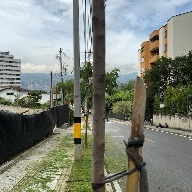

In [9]:
sample_image

In [20]:
prediction = model.inference(
    [sample_image],
    use_ray_pose=True,
    ref_view_strategy="saddle_balanced",
    export_feat_layers=[0, 1, 2]
)
prediction2 = model.inference(
    [sample_image],
    use_ray_pose=False,
    ref_view_strategy="saddle_balanced"
)

[INFO ] Processed Images Done taking 0.04274129867553711 seconds. Shape:  torch.Size([1, 3, 504, 504])
[INFO ] Model Forward Pass Done. Time: 9.831132888793945 seconds
[INFO ] Conversion to Prediction Done. Time: 0.010974884033203125 seconds
[INFO ] Processed Images Done taking 0.015856027603149414 seconds. Shape:  torch.Size([1, 3, 504, 504])
[INFO ] Model Forward Pass Done. Time: 7.9433324337005615 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010004043579101562 seconds


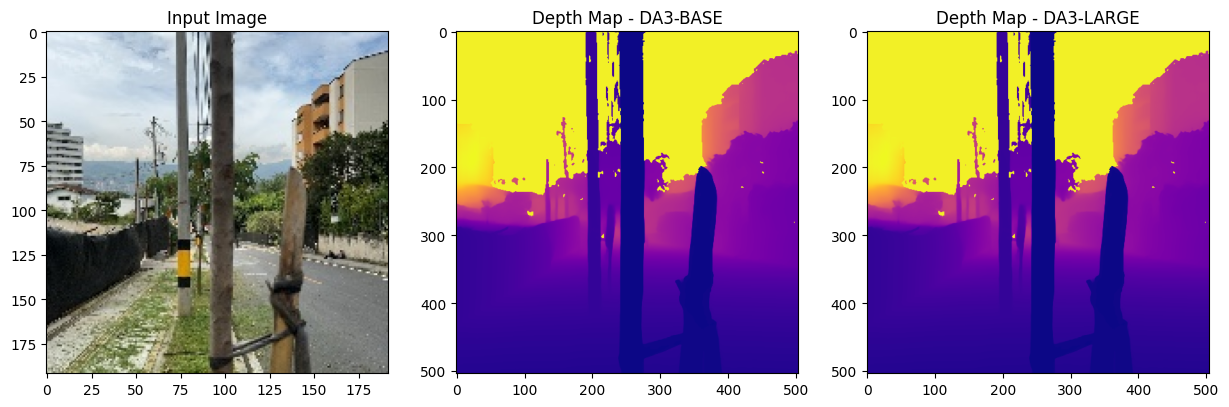

In [21]:
# show image and depth map
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(sample_image)
ax[0].set_title("Input Image")
ax[1].imshow(prediction.depth[0], cmap="plasma")
ax[1].set_title("Depth Map - DA3-BASE")
ax[2].imshow(prediction2.depth[0], cmap="plasma")
ax[2].set_title("Depth Map - DA3-LARGE")
plt.show()


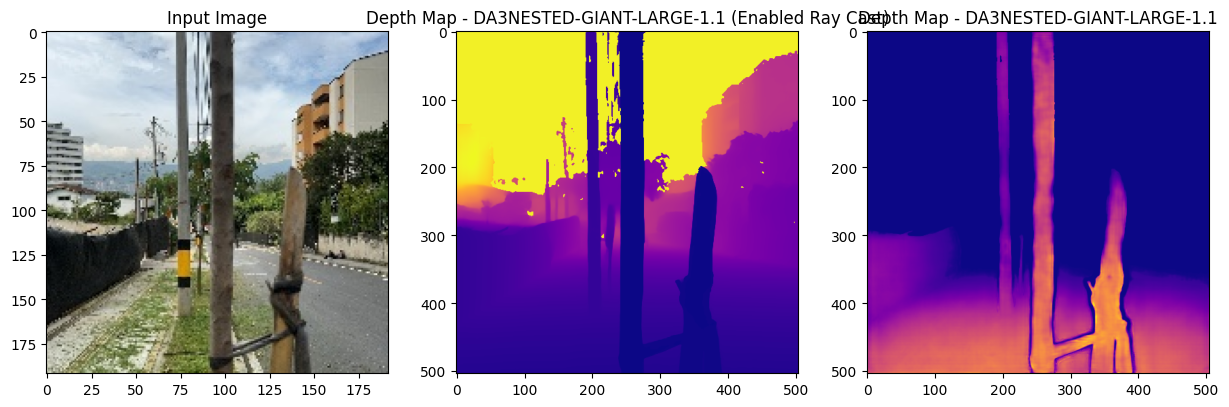

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(sample_image)
ax[0].set_title("Input Image")
ax[1].imshow(prediction.depth[0], cmap="plasma")
ax[1].set_title("Depth Map - DA3NESTED-GIANT-LARGE-1.1 (Enabled Ray Cast)")
ax[2].imshow(prediction2.conf[0], cmap="plasma")
ax[2].set_title("Depth Map - DA3NESTED-GIANT-LARGE-1.1")
plt.show()


['depth', 'is_metric', 'sky', 'conf', 'extrinsics', 'intrinsics', 'processed_images', 'gaussians', 'aux', 'scale_factor']


In [ ]:
base_path = "../dataset/DepthMapDBH2023/"
model_name = "DA3NESTED-GIANT-LARGE-1.1"

import torch
import numpy as np

def to_numpy_safe(x):
    if x is None:
        return None

    # torch tensor
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()

    # numpy array
    if isinstance(x, np.ndarray):
        return x

    # list / tuple → try first element (batched outputs)
    if isinstance(x, (list, tuple)) and len(x) > 0:
        return to_numpy_safe(x[0])

    # anything else → not saveable
    return None


for split in ["train", "test"]:
    df_split = pd.read_csv(
        Path(base_path) / split / split / "files.csv",
        index_col=0,
    )

    # will collect paths per prediction key
    prediction_paths = {}  # key -> list of paths

    for idx, row in tqdm(list(df_split.iterrows())):
        img_path = Path(base_path) / split / row["image_path"]
        image = Image.open(img_path).convert("RGB")

        prediction = model.inference(
            [image],
            use_ray_pose=True,
            ref_view_strategy="saddle_balanced",
        )

        # get all prediction fields safely
        # works for dataclasses / objects
        pred_dict = vars(prediction)

        for key, value in pred_dict.items():
            if value is None:
                continue

            # assume batched outputs → take first element
            try:
                data = value[0]
            except Exception:
                data = value

            output_dir = (
                Path(base_path)
                / split
                / split
                / "depth_anything_maps"
                / model_name
                / key
            )
            output_dir.mkdir(parents=True, exist_ok=True)

            out_path = output_dir / f"{split}_{idx}_{key}.npy"

            data = to_numpy_safe(value)

            if data is None:
                continue

            np.save(out_path, data)

            rel_path = str(out_path.relative_to(base_path).as_posix())

            if key not in prediction_paths:
                prediction_paths[key] = []

            prediction_paths[key].append(rel_path)

    # append one column per prediction key
    for key, paths in prediction_paths.items():
        df_split[f"{key}_path"] = paths

    df_split.to_csv(
        Path(base_path)
        / split
        / split
        / f"files_with_all_predictions_{model_name}.csv",
        index=False,
    )

  0%|          | 0/1008 [00:00<?, ?it/s]

[INFO ] Processed Images Done taking 0.024007797241210938 seconds. Shape:  torch.Size([1, 3, 504, 504])
[INFO ] Model Forward Pass Done. Time: 10.417925357818604 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010006427764892578 seconds
[INFO ] Processed Images Done taking 0.016001224517822266 seconds. Shape:  torch.Size([1, 3, 504, 504])
[INFO ] Model Forward Pass Done. Time: 11.02783203125 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0009999275207519531 seconds
[INFO ] Processed Images Done taking 0.01503443717956543 seconds. Shape:  torch.Size([1, 3, 504, 504])
[INFO ] Model Forward Pass Done. Time: 11.089724779129028 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010004043579101562 seconds
[INFO ] Processed Images Done taking 0.01500844955444336 seconds. Shape:  torch.Size([1, 3, 504, 504])
[INFO ] Model Forward Pass Done. Time: 11.140555381774902 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0 seconds
[INFO ] Processed Images Done taking 0.02100

KeyboardInterrupt: 

In [15]:
depth_anything_csv = pd.read_csv("../dataset/DepthMapDBH2023/train/train/files_with_depth_maps_DA3_LARGE.csv")
depth_anything_csv.head()

,image_path,depth_map_path,DBH,depth_anything_maps_path
0,train/images/0.jpg,train/depth_maps/0.png,3.023944,train\train\depth_anything_maps\DA3-LARGE\trai...
1,train/images/1.jpg,train/depth_maps/1.png,2.069014,train\train\depth_anything_maps\DA3-LARGE\trai...
2,train/images/2.jpg,train/depth_maps/2.png,2.228169,train\train\depth_anything_maps\DA3-LARGE\trai...
3,train/images/3.jpg,train/depth_maps/3.png,14.960565,train\train\depth_anything_maps\DA3-LARGE\trai...
4,train/images/4.jpg,train/depth_maps/4.png,15.915494,train\train\depth_anything_maps\DA3-LARGE\trai...


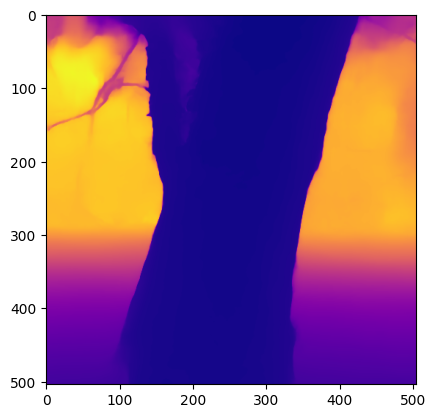

In [ ]:
    n = np.load(Path(base_path) / depth_anything_csv["depth_anything_maps_path"][200])
    plt.imshow(n, cmap="plasma")

In [50]:
n.shape

(504, 504)

In [2]:
import numpy as np
np.load("../dataset/DepthMapDBH2023/test/test/depth_anything_maps/DA3-LARGE/test_0_depth_map.npy").shape

(504, 504)